# Machine Learning Methods for Empirical Dynamic Modeling

_Kevin Siswandi | July 2020_

We demonstrate a few approaches for empirical dynamic modeling with machine learning tools:
* One-step Learning
* LmmNet
* Recurrent Neural Network (maybe)

Here we will demonstrate it on the canonical 3-D Linear Oscillator. Later, we will try to see how it performs with noisy data. Finally, we see how the method can extract insights from what it has learnt from data.

In [1]:
import sys
sys.path.append("./source")

# libraries for this project
from lmmNet import *
import linear
import train_onestep
import predict_onestep
import predict_lmmNet

import numpy as np
from scipy.integrate import odeint
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits import mplot3d

The dynamics of the test problem considered here is given by the linear ODE:

<img src=image/linear-equation.png alt="drawing" align ="centre" width="300"/>   
with the initial condition $(x_0, y_0, z_0) = (2,0,1)$.

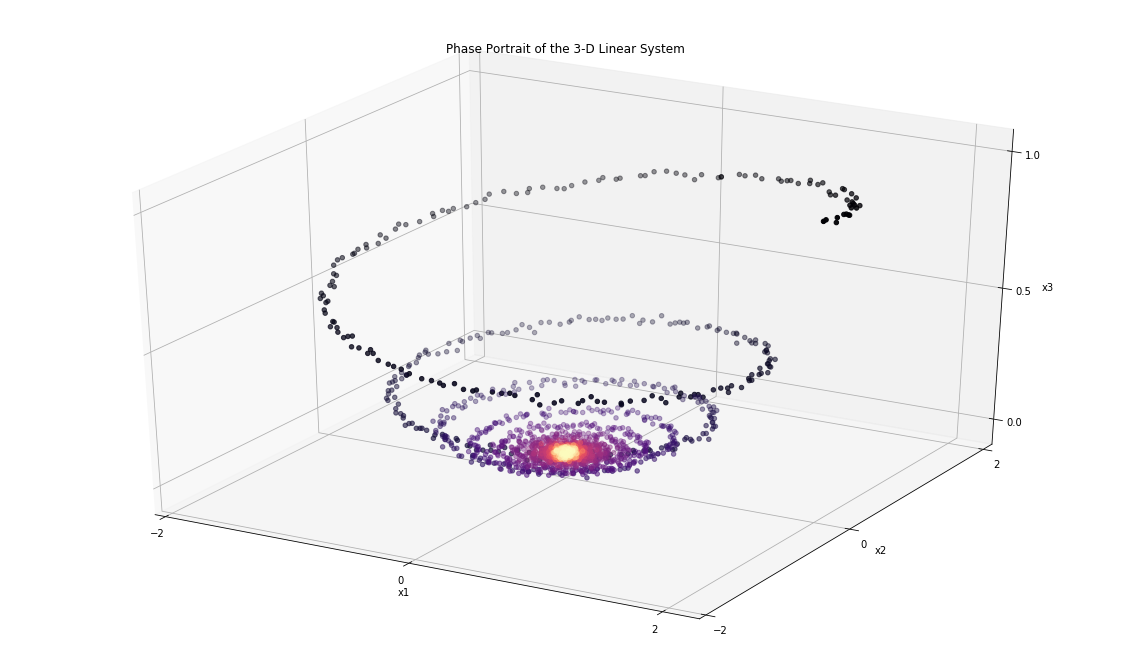

In [2]:
time_points, linear_data = linear.simulate_custom(noise=0.05, step=0.02)

# Phase portrait
fig = plt.figure(figsize=(20, 12))
ax = plt.axes(projection='3d')
ax.scatter3D(linear_data[0,:,0], linear_data[0,:,1], linear_data[0,:,2], c=time_points, cmap='magma')
#ax.grid(False)
ax.set_title('Phase Portrait of the 3-D Linear System')
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_zlabel("x3")
ax.set_xticks([-2,0, 2 ])
ax.set_yticks([-2,0, 2 ])
ax.set_zticks([0, 0.5, 1])
plt.show()

## 1. LmmNet

Training is done to find the optimal parameters via minimising loss function:

$$ \arg \min_w \frac{1}{N - M + 1} \sum_{n = M}^{N} |\textbf{y}_n|^2 $$

where N is the number of data points and M multi steps. The linear difference/residual operator is defined as

$$ \textbf{y}_n = \sum_{n=0}^M \left(\alpha_m x_{n-m} + h \beta_m \textbf{f}(\textbf{x}_{n-m}) \right)$$

for $n=M,...,N$.

In [3]:
# we specify a LMM scheme and number of steps
dt = time_points[1] - time_points[0]
M = 1
scheme = 'AM'
model = lmmNet(dt, linear_data, M, scheme, hidden_units=256)

N_Iter = 10000
model.train(N_Iter, debug=False)

In [4]:
x0 = linear_data[0,0,:] # initial conditions
predicted_traj = odeint(lambda x, t: predict_lmmNet.predict_fn(x, t, model), x0, time_points)

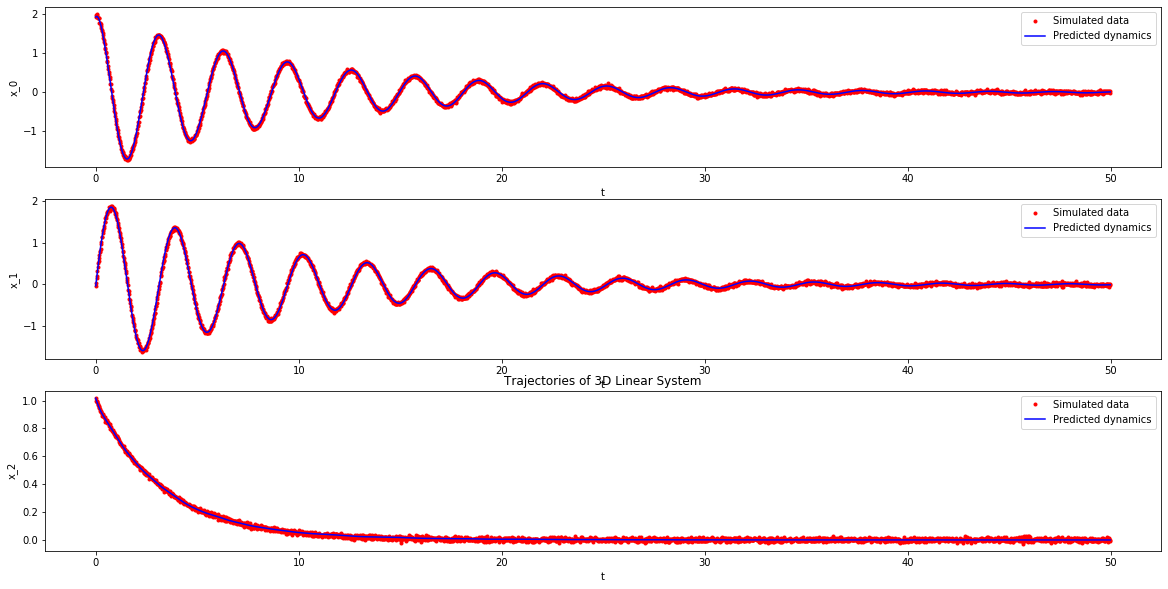

In [5]:
# plot the time-course of the predicted trajectory

plt.figure(figsize=(20, 10))

for species in range(3):
    plt.subplot(3,1,species + 1)
    plt.plot(time_points, linear_data[0,:, species], 'r.', label='Simulated data')
    plt.plot(time_points, predicted_traj[:,species], 'b-', label='Predicted dynamics')
    plt.xlabel('t')
    plt.ylabel('x_' + str(species))
    plt.legend()
    
plt.title('Trajectories of 3D Linear System')
plt.show()

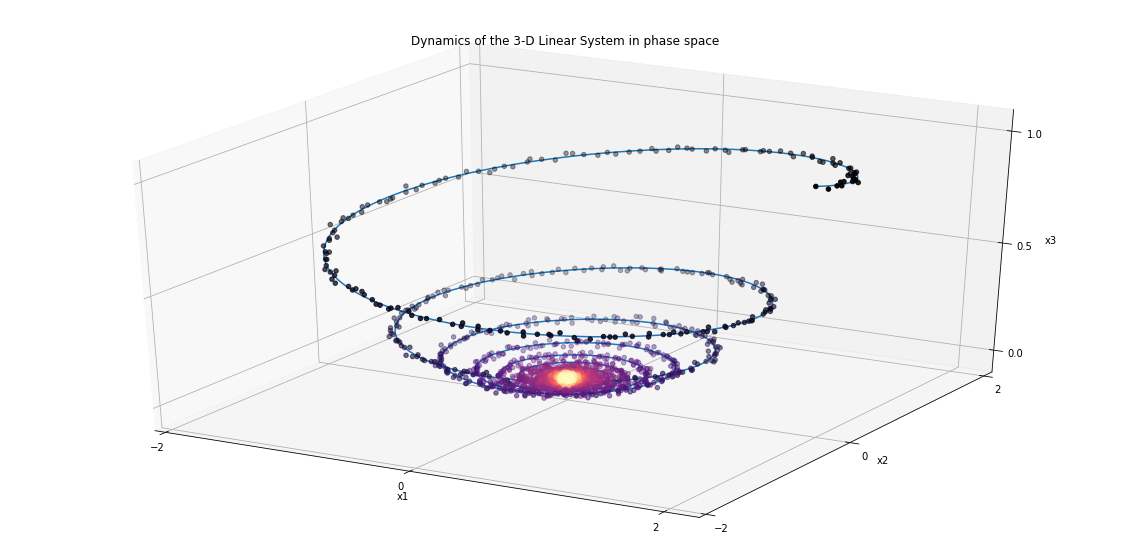

In [6]:
# Phase portrait
fig = plt.figure(figsize=(20,10))
ax = plt.axes(projection='3d')
ax.scatter3D(linear_data[0,:,0], linear_data[0,:,1], linear_data[0,:,2], c=time_points, cmap='magma')
ax.plot3D(predicted_traj[:,0], predicted_traj[:,1], predicted_traj[:,2])
#ax.grid(False)
ax.set_title('Dynamics of the 3-D Linear System in phase space')
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_zlabel("x3")
ax.set_xticks([-2,0, 2 ])
ax.set_yticks([-2,0, 2 ])
ax.set_zticks([0, 0.5, 1])
plt.show()

In [9]:
# now we try it on a test data
print("The time step is: ", dt)
time_points, test_data = linear.simulate_custom(xinit=3, yinit=4, zinit=2, step=dt)
predicted_test = odeint(lambda x, t: predict_lmmNet.predict_fn(x, t, model), test_data[0,0,:], time_points)

The time step is:  0.02


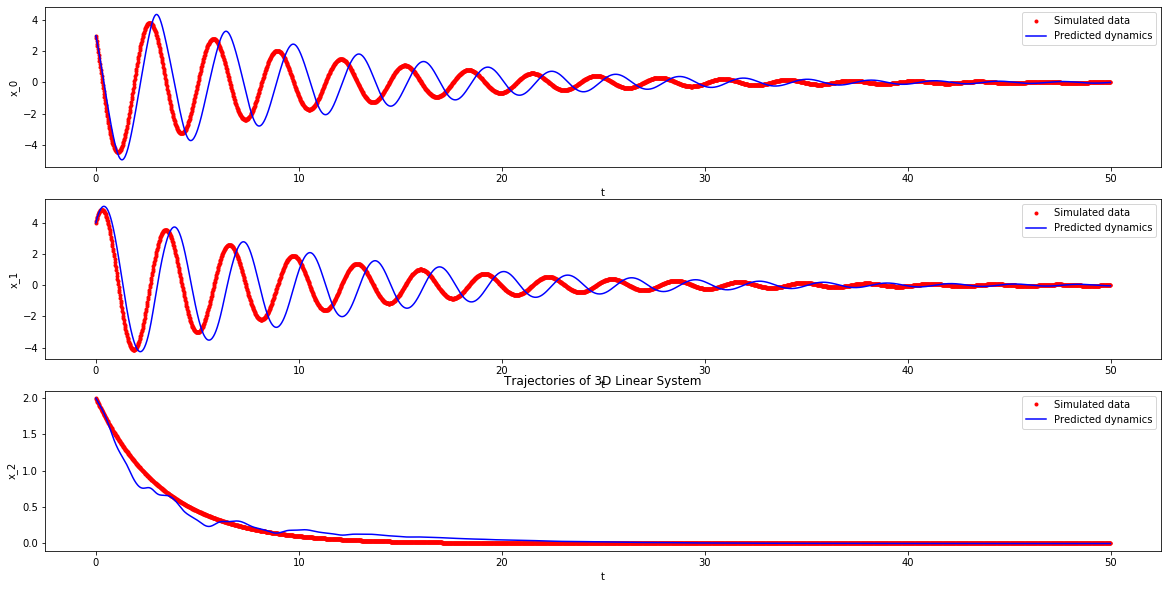

In [10]:
# plot the time-course of the predicted trajectory

plt.figure(figsize=(20, 10))

for species in range(3):
    plt.subplot(3,1,species + 1)
    plt.plot(time_points, test_data[0,:, species], 'r.', label='Simulated data')
    plt.plot(time_points, predicted_test[:,species], 'b-', label='Predicted dynamics')
    plt.xlabel('t')
    plt.ylabel('x_' + str(species))
    plt.legend()
    
plt.title('Trajectories of 3D Linear System')
plt.show()

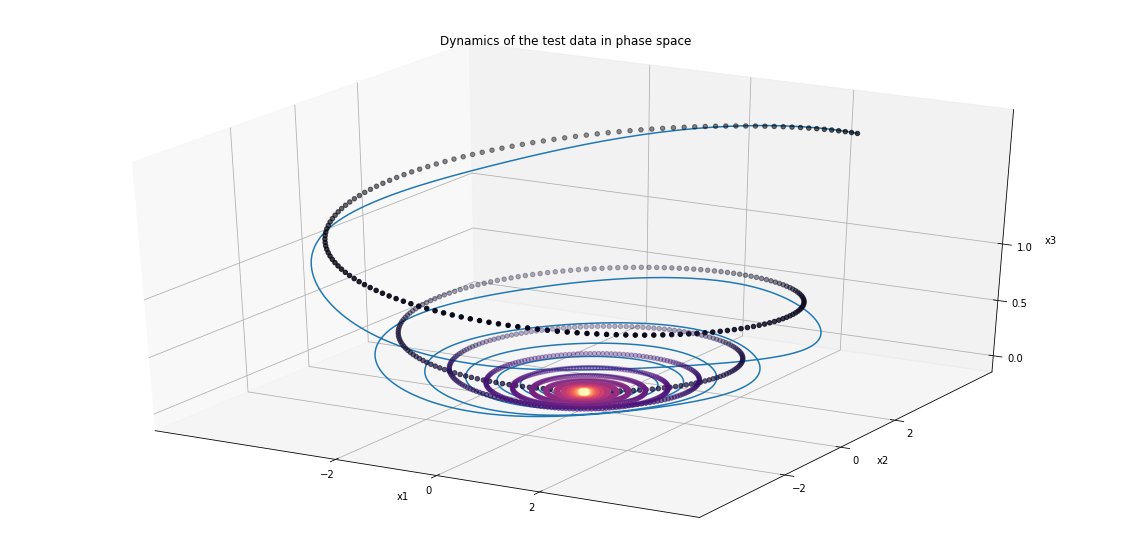

In [11]:
# Phase portrait
fig = plt.figure(figsize=(20,10))
ax = plt.axes(projection='3d')
ax.scatter3D(test_data[0,:,0], test_data[0,:,1], test_data[0,:,2], c=time_points, cmap='magma')
ax.plot3D(predicted_test[:,0], predicted_test[:,1], predicted_test[:,2])
#ax.grid(False)
ax.set_title('Dynamics of the test data in phase space')
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_zlabel("x3")
ax.set_xticks([-2,0, 2 ])
ax.set_yticks([-2,0, 2 ])
ax.set_zticks([0, 0.5, 1])
plt.show()

## 2. One-step Learning

Notes:
* The test data is generated noise-free
* Data are (0, 50) with step 0.02, so total 2500 points

In [3]:
from utils import *

feature_list = []
target_list = ['x_component', 'y_component', 'z_component']
df = create_data(linear_data, time_points, cols=target_list)
print("Shape of the tensor is: ", linear_data.shape)

Shape of the dataframe is: (2500, 4)
Shape of the tensor is:  (1, 2500, 3)


In [4]:
# create training data with different augmentation

df_train = train_onestep.generate_dataset(df, [0],feature_list, target_list, n_dim=2500)
df_train2 = train_onestep.generate_dataset(df, [0],feature_list, target_list, n_dim=5000)
df_train3 = train_onestep.generate_dataset(df, [0],feature_list, target_list, n_dim=10000)
df_train4 = train_onestep.generate_dataset(df, [0],feature_list, target_list, n_dim=20000)

x_component


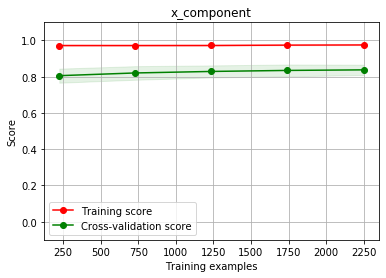

Target: x_component, CV Pearson R2 coefficient: 0.975141
y_component


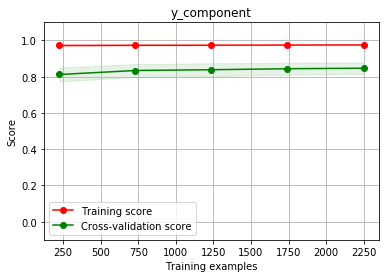

Target: y_component, CV Pearson R2 coefficient: 0.975690
z_component


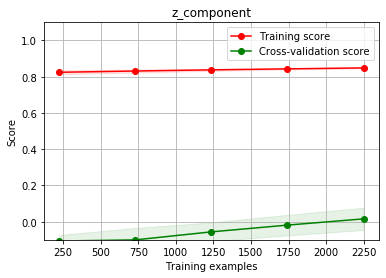

Target: z_component, CV Pearson R2 coefficient: 0.851493
Average training score: 0.9341082685329493
x_component RMSE: -0.001739698282226059 standard deviation: 0.1529962019482574


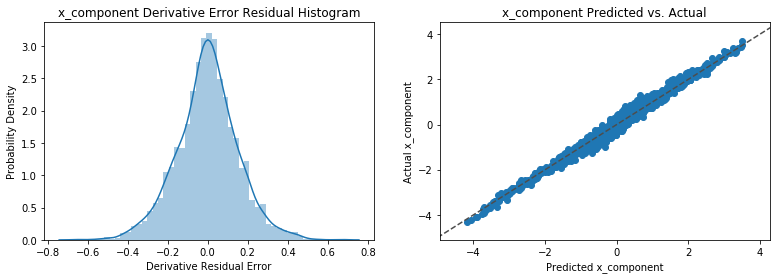

y_component RMSE: 0.004134871135590832 standard deviation: 0.1507237839768988


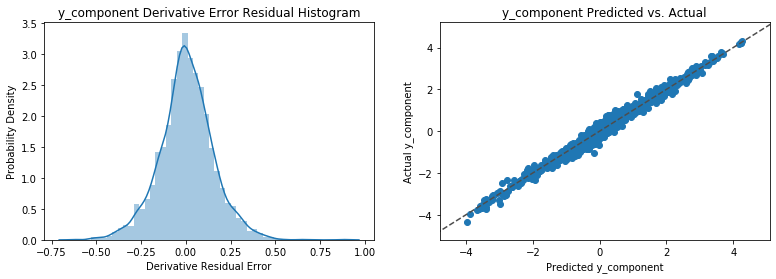

z_component RMSE: 0.00023478863475991308 standard deviation: 0.05707700035225637


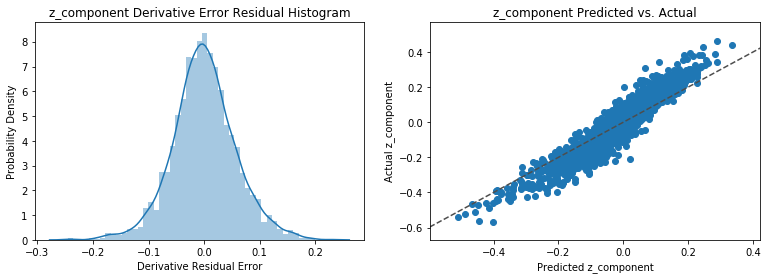

Total Derivative Mean Error: 0.5771463384832605 Error Standard Deviation: 0.1247852937523051


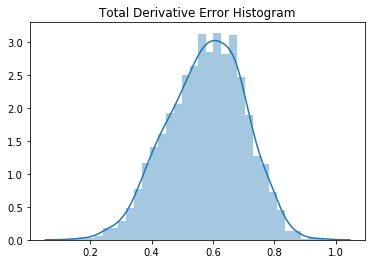

Real data:


,x_component,y_component,z_component
Strain,,,
0,1.986148,-0.002801,1.003993
0,1.952628,0.094500,0.994270
0,2.010650,0.142697,0.999983
0,1.953246,0.239718,0.965925
0,1.957928,0.332835,0.982625
...,...,...,...
0,0.016252,-0.044528,0.004674
0,0.044662,-0.027187,0.018178
0,0.043692,-0.011873,-0.007574


Predicted data:


,x_component,y_component,z_component
Time,,,
0.00,1.986148,-0.002801,1.003993
0.02,1.984634,0.081968,0.996116
0.04,1.975579,0.166586,0.988273
0.06,1.966126,0.251758,0.980410
0.08,1.952372,0.336575,0.972785
...,...,...,...
49.90,-0.027013,-0.008099,0.000117
49.92,-0.026761,-0.008472,0.000123
49.94,-0.026778,-0.008916,0.000188


./source/predict_onestep.py:217: IntegrationWarning: The maximum number of subdivisions (200) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  rmse = math.sqrt(quad(integrand,min(times),max(times),limit=200)[0])
./source/predict_onestep.py:222: IntegrationWarning: The maximum number of subdivisions (200) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  

ML Fit: x_component 0.6925921060470019 RMSE percentage: 133.9388089141311
ML Fit: y_component 0.6540232009225283 RMSE percentage: 134.5348276018638
ML Fit: z_component 0.1471795735003379 RMSE percentage: 193.0635513882736
ML model aggregate error
Average RMSE: 0.49793162682328934
Total percentage error: 153.84572930142284


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


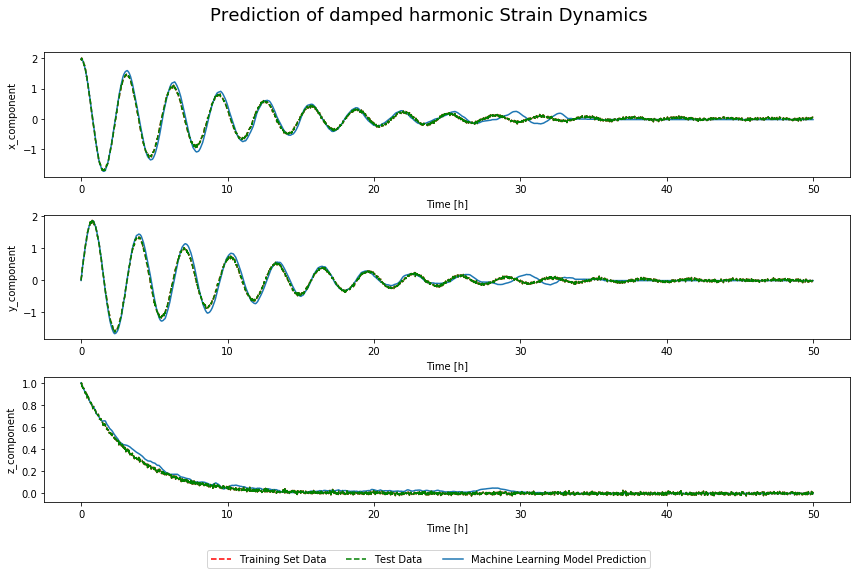

x_component


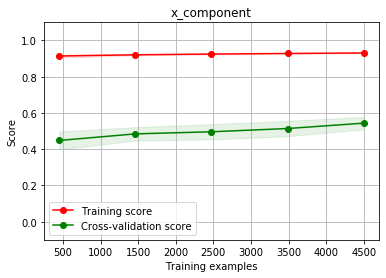

Target: x_component, CV Pearson R2 coefficient: 0.933236
y_component


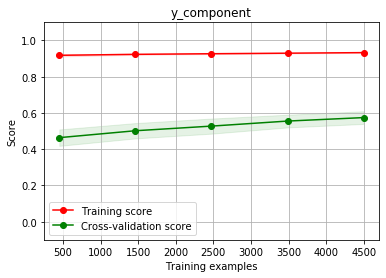

Target: y_component, CV Pearson R2 coefficient: 0.932531
z_component


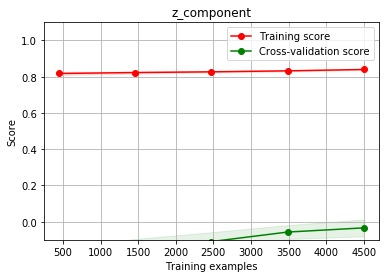

Target: z_component, CV Pearson R2 coefficient: 0.838923
Average training score: 0.9015636812426252
x_component RMSE: 0.0014339514272522038 standard deviation: 0.30667025727012165


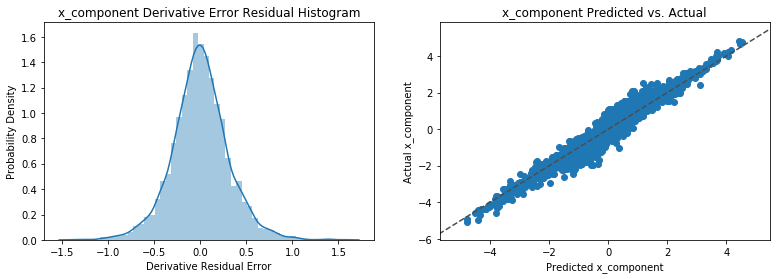

y_component RMSE: 0.0029354885643166745 standard deviation: 0.3085927817413053


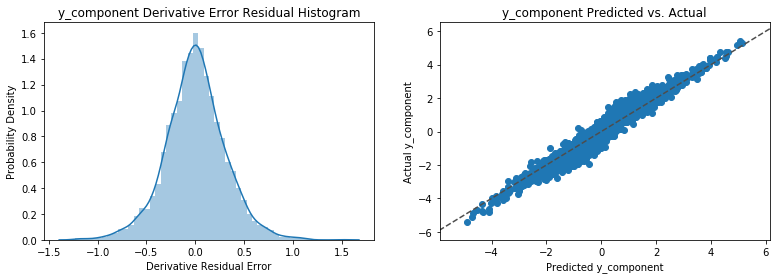

z_component RMSE: -0.0008019638138177449 standard deviation: 0.11795454401847039


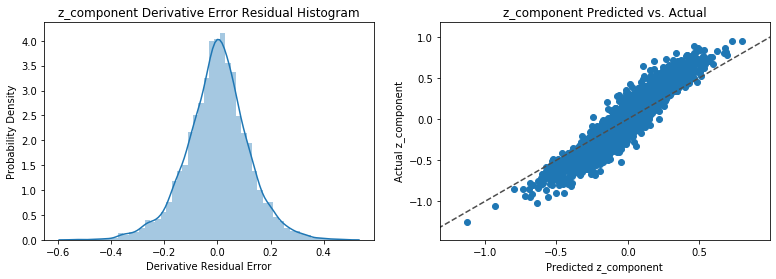

Total Derivative Mean Error: 0.7201697176906481 Error Standard Deviation: 0.15309039900466784


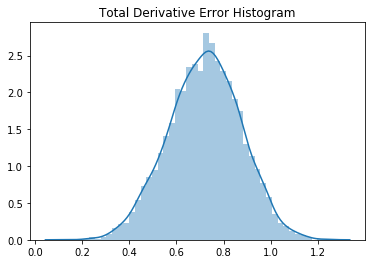

Real data:


,x_component,y_component,z_component
Strain,,,
0,1.986148,-0.002801,1.003993
0,1.952628,0.094500,0.994270
0,2.010650,0.142697,0.999983
0,1.953246,0.239718,0.965925
0,1.957928,0.332835,0.982625
...,...,...,...
0,0.016252,-0.044528,0.004674
0,0.044662,-0.027187,0.018178
0,0.043692,-0.011873,-0.007574


Predicted data:


,x_component,y_component,z_component
Time,,,
0.00,1.986148,-0.002801,1.003993
0.02,1.989024,0.071842,0.996699
0.04,1.987038,0.144813,0.986180
0.06,1.973817,0.228977,0.975908
0.08,1.955894,0.328508,0.971324
...,...,...,...
49.90,-0.064470,0.114619,-0.008516
49.92,-0.065377,0.113879,-0.008798
49.94,-0.065529,0.114165,-0.008570


./source/predict_onestep.py:217: IntegrationWarning: The maximum number of subdivisions (200) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  rmse = math.sqrt(quad(integrand,min(times),max(times),limit=200)[0])
./source/predict_onestep.py:222: IntegrationWarning: The maximum number of subdivisions (200) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  

ML Fit: x_component 2.93058405997852 RMSE percentage: 265.3232054949487
ML Fit: y_component 2.810611008830231 RMSE percentage: 319.9803478913733
ML Fit: z_component 0.2849128732497842 RMSE percentage: 268.4715710078532
ML model aggregate error
Average RMSE: 2.008702647352845
Total percentage error: 284.5917081313917


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


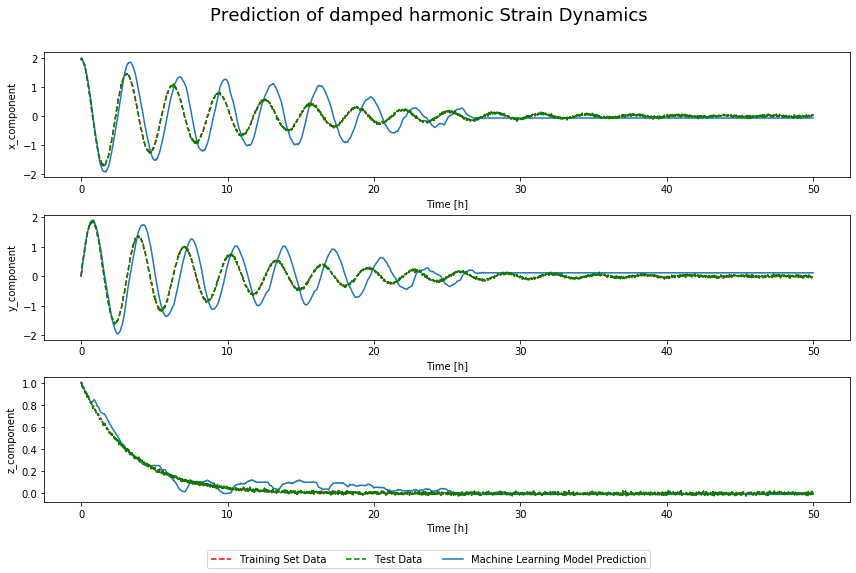

x_component


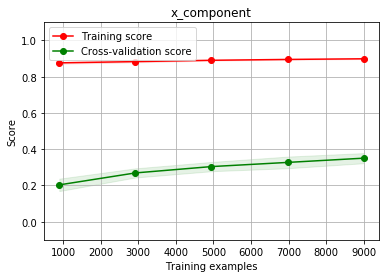

Target: x_component, CV Pearson R2 coefficient: 0.901526
y_component


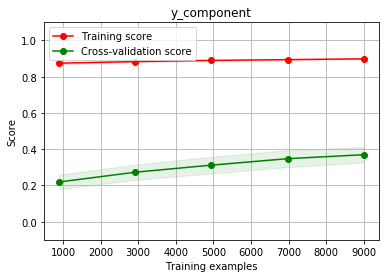

Target: y_component, CV Pearson R2 coefficient: 0.901784
z_component


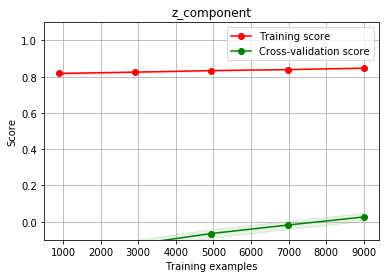

Target: z_component, CV Pearson R2 coefficient: 0.852748
Average training score: 0.8853526932369563
x_component RMSE: 0.0047612529874792925 standard deviation: 0.4896701867099633


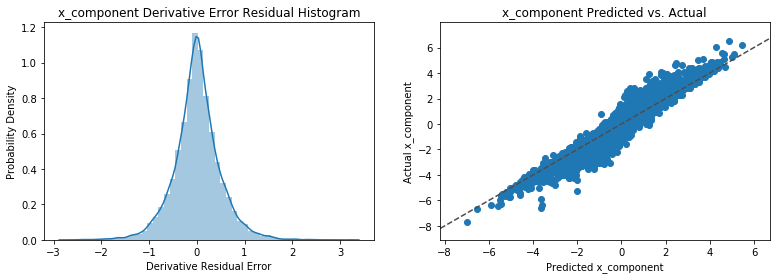

y_component RMSE: -0.0009070555163231532 standard deviation: 0.4892130827597837


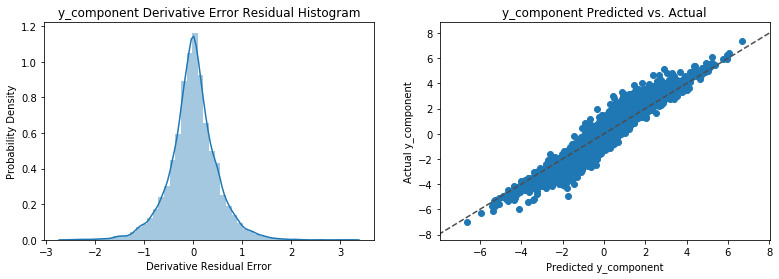

z_component RMSE: -0.0006217363291741372 standard deviation: 0.1840693328623276


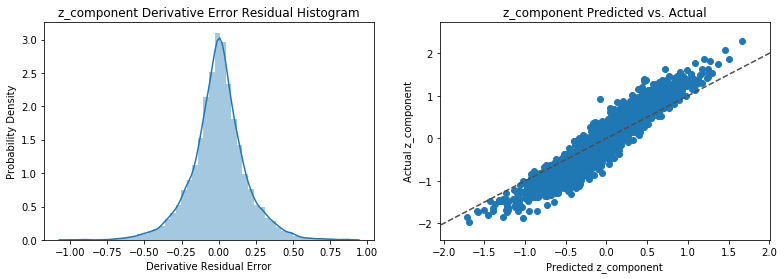

Total Derivative Mean Error: 0.8261645269211585 Error Standard Deviation: 0.20763135547091024


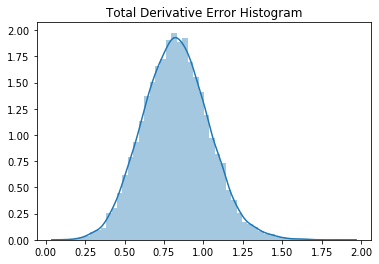

Real data:


,x_component,y_component,z_component
Strain,,,
0,1.986148,-0.002801,1.003993
0,1.952628,0.094500,0.994270
0,2.010650,0.142697,0.999983
0,1.953246,0.239718,0.965925
0,1.957928,0.332835,0.982625
...,...,...,...
0,0.016252,-0.044528,0.004674
0,0.044662,-0.027187,0.018178
0,0.043692,-0.011873,-0.007574


Predicted data:


,x_component,y_component,z_component
Time,,,
0.00,1.986148,-0.002801,1.003993
0.02,2.005342,0.081775,0.993464
0.04,2.030472,0.151859,0.976954
0.06,1.997724,0.228135,0.950861
0.08,1.970535,0.300662,0.930018
...,...,...,...
49.90,0.052168,-0.005118,0.042805
49.92,0.052542,-0.005205,0.043350
49.94,0.051740,-0.005445,0.043456


./source/predict_onestep.py:217: IntegrationWarning: The maximum number of subdivisions (200) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  rmse = math.sqrt(quad(integrand,min(times),max(times),limit=200)[0])
./source/predict_onestep.py:222: IntegrationWarning: The maximum number of subdivisions (200) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  

ML Fit: x_component 1.6816878784232467 RMSE percentage: 161.98854369184573
ML Fit: y_component 1.69474999686094 RMSE percentage: 121.17790618569333
ML Fit: z_component 0.3140912698570824 RMSE percentage: 252.02013809234796
ML model aggregate error
Average RMSE: 1.2301763817137563
Total percentage error: 178.39552932329568


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


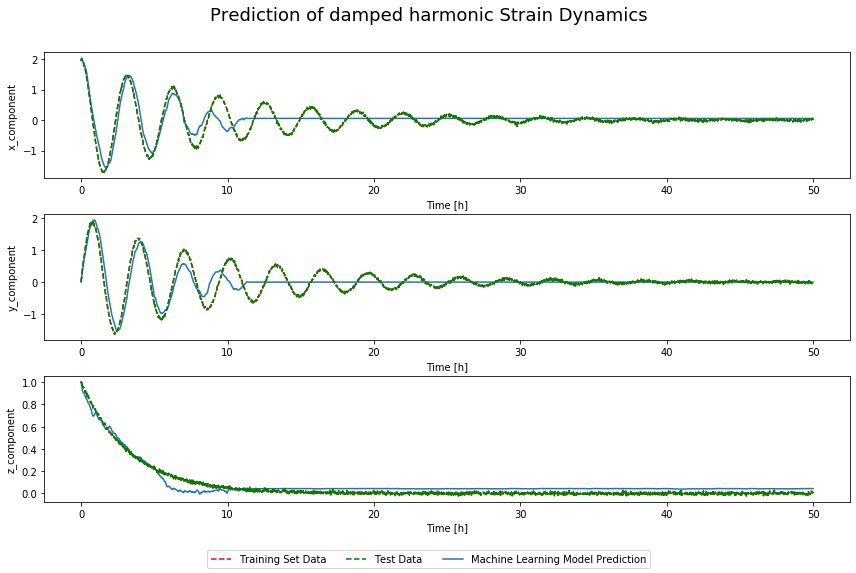

x_component


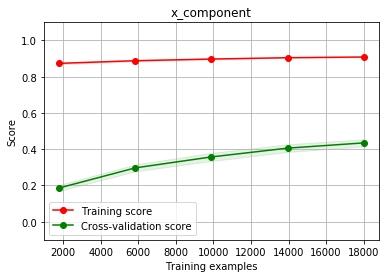

Target: x_component, CV Pearson R2 coefficient: 0.910729
y_component


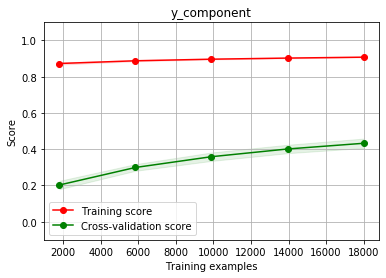

Target: y_component, CV Pearson R2 coefficient: 0.909643
z_component


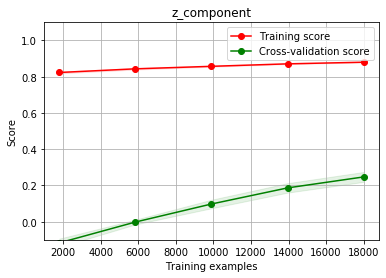

Target: z_component, CV Pearson R2 coefficient: 0.883896
Average training score: 0.9014226513897436
x_component RMSE: 0.002341313231721032 standard deviation: 0.5112340954378417


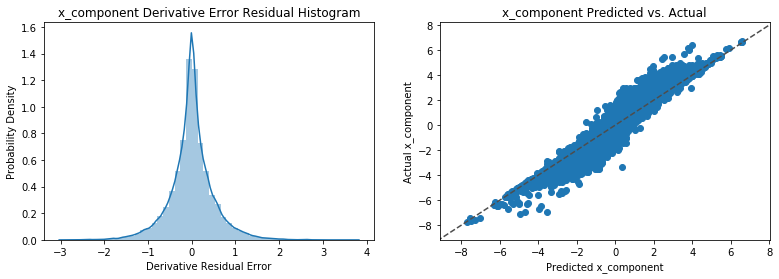

y_component RMSE: 0.001575291942322125 standard deviation: 0.514671973049314


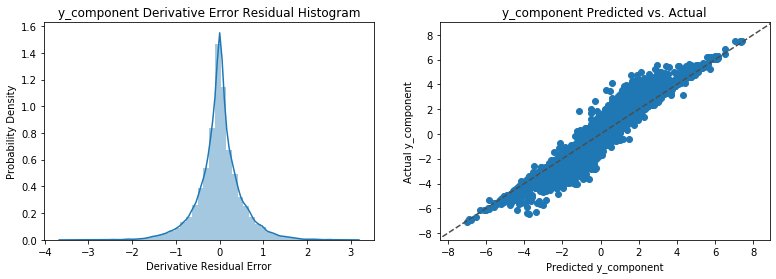

z_component RMSE: -0.0004308182080979431 standard deviation: 0.1865726409398486


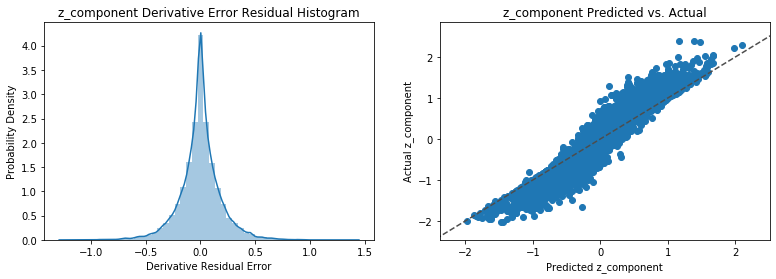

Total Derivative Mean Error: 0.8077679728672119 Error Standard Deviation: 0.24526295419972854


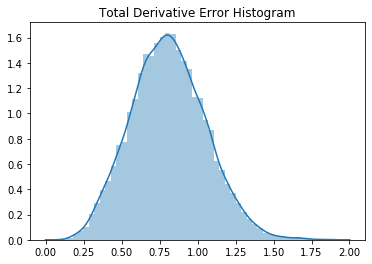

Real data:


,x_component,y_component,z_component
Strain,,,
0,1.986148,-0.002801,1.003993
0,1.952628,0.094500,0.994270
0,2.010650,0.142697,0.999983
0,1.953246,0.239718,0.965925
0,1.957928,0.332835,0.982625
...,...,...,...
0,0.016252,-0.044528,0.004674
0,0.044662,-0.027187,0.018178
0,0.043692,-0.011873,-0.007574


Predicted data:


,x_component,y_component,z_component
Time,,,
0.00,1.986148,-0.002801,1.003993
0.02,1.985131,0.088511,0.996706
0.04,2.016672,0.146890,0.992874
0.06,1.971996,0.239773,0.964214
0.08,1.958631,0.317731,0.964117
...,...,...,...
49.90,-0.206013,0.024901,-0.020964
49.92,-0.207291,0.024937,-0.020949
49.94,-0.205531,0.024785,-0.020943


./source/predict_onestep.py:217: IntegrationWarning: The maximum number of subdivisions (200) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  rmse = math.sqrt(quad(integrand,min(times),max(times),limit=200)[0])
./source/predict_onestep.py:222: IntegrationWarning: The maximum number of subdivisions (200) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  

ML Fit: x_component 2.2318489060879623 RMSE percentage: 305.4760027165953
ML Fit: y_component 1.9468770102950719 RMSE percentage: 154.27551666040424
ML Fit: z_component 0.4874776043723905 RMSE percentage: 312.65675629509866
ML model aggregate error
Average RMSE: 1.5554011735851416
Total percentage error: 257.46942522403276


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


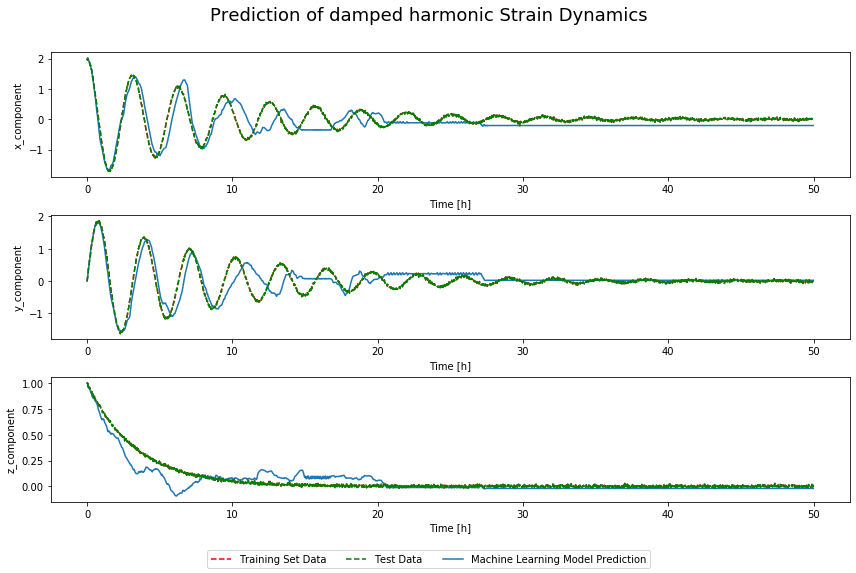

In [5]:
tp1, pred1 = end_to_end_training(df, df_train, df, feature_list, target_list, (3,1))
tp2, pred2 = end_to_end_training(df, df_train2, df, feature_list, target_list, (3,1))
tp3, pred3 = end_to_end_training(df, df_train3, df, feature_list, target_list, (3,1))
tp4, pred4 = end_to_end_training(df, df_train4, df, feature_list, target_list, (3,1))

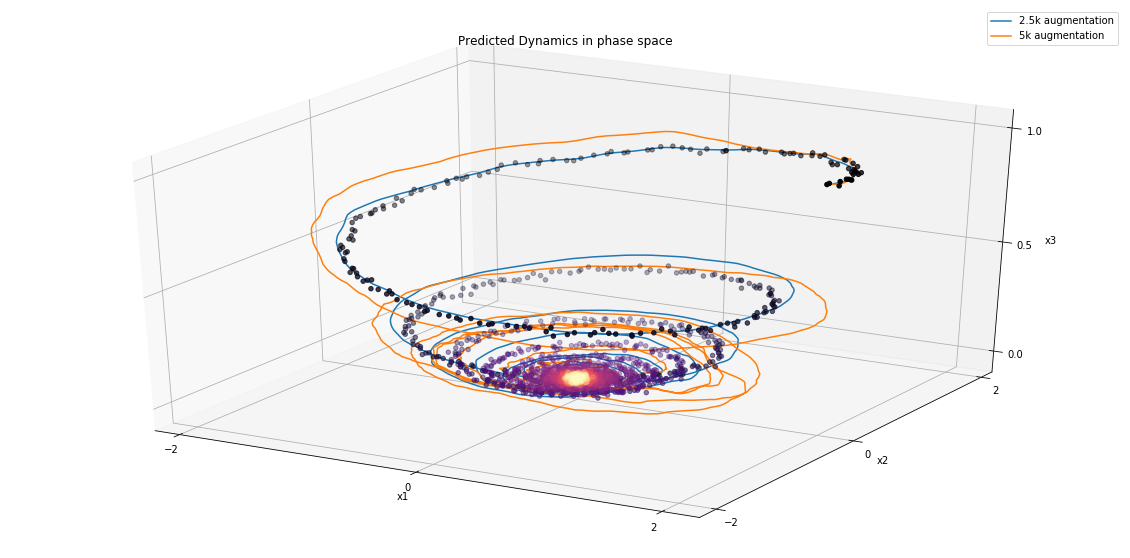

In [6]:
# Phase portrait
fig = plt.figure(figsize=(20,10))
ax = plt.axes(projection='3d')
ax.scatter3D(linear_data[0,:,0], linear_data[0,:,1], linear_data[0,:,2], c=time_points, cmap='magma')
ax.plot3D(pred1.iloc[:,0], pred1.iloc[:,1], pred1.iloc[:,2], label='2.5k augmentation')
ax.plot3D(pred2.iloc[:,0], pred2.iloc[:,1], pred2.iloc[:,2], label='5k augmentation')
#ax.grid(False)
ax.set_title('Predicted Dynamics in phase space')
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_zlabel("x3")
ax.set_xticks([-2,0, 2 ])
ax.set_yticks([-2,0, 2 ])
ax.set_zticks([0, 0.5, 1])
ax.legend()
plt.show()